# Reproducibility in different acquisition settings

This notebook aims to understand whether the acquisition setting and age has impact on reproducibility metrics on mature brains. In this analysis two open-data sharing initiatives were used: IXI and OASIS-3. The analysis was conducted per acquisition setting. Therefore, four groups were analysed: three groups for the IXI dataset (one per site/acquisition setting) and one group for the OASIS-3.

In [1]:
#@title

import os
import math
import matplotlib
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import LinearRegression
from settings import RESOURCE_DIR
from utils import get_regression_metrics, bland_altman_plot

# Tables format
pd.set_option('display.float_format', lambda x: f"{x: 0.2e}")

# Visualization format
font = {'size'   : 18}
matplotlib.rc('font', **font)
sns.set_theme(style="whitegrid", font_scale=2)

# Global variables
var_compare = "repository_and_site"
template_name = "a2009s"
metric_analysis = "corticalThicknessAverage"
path_csv_cortical_data = "cortical_thicknesss_different_acquisition_settings.csv"

color_pallete = {"IXI|Guys": "#D81B60", "IXI|HH": "#1E88E5", "IXI|IOP": "#FFC107", "OASIS3": "#004D40"}

var_analyse = ["r_square", "slope", "intercept"]

pipeline1 = "ACPC_CAT12"
pipeline2 = "FREESURFER"

/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#@title


df_names_rois = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_atlas_labels.csv"))
df_areas = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_rois_areas.csv"))

## Data

In [3]:
#@title
df_software_raw = pd.read_csv(os.path.join(RESOURCE_DIR, "data", path_csv_cortical_data), low_memory=False)
df_software_raw.set_index("path", inplace=True)
# Get only the template ROIs
df_software_raw = df_software_raw.loc[df_software_raw.roiName.str[1:].isin(df_names_rois.label.to_list())]

df_software_raw["repository_and_site"] = df_software_raw.apply(lambda x: x["repositoryName"] if (type(x["site"]) == float and math.isnan(x["site"])) or len(x["site"]) == 0 else x["repositoryName"]+ "|" + x["site"], axis=1)
df_software_raw.head(4)

repositoryName  site subjectID  \
path                                                                      
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI  Guys   sub-002   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI  Guys   sub-002   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI  Guys   sub-002   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI  Guys   sub-002   

                                         sessionID  run  gender       age  \
path                                                                        
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz         1    1  FEMALE  3.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz         1    1  FEMALE  3.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz         1    1  FEMALE  3.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz         1    1  FEMALE  3.58e+01   

                                            software  \
path                                                   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  ACPC_CAT12   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  ACPC_CAT12   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  ACPC_CAT12   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  ACPC_CAT12   

                                                           roiName  \
path                                                                 
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  lG_Ins_lg_and_S_cent_ins   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz       lG_and_S_cingul-Ant   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   lG_and_S_cingul-Mid-Ant   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  lG_and_S_cingul-Mid-Post   

                                          corticalThicknessAverage template  \
path                                                                          
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                  3.16e+00   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                  2.56e+00   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                  2.69e+00   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                  2.69e+00   a2009s   

                                               cjv       cnr  snr_total  \
path                                                                      
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  3.35e-01  4.06e+00   1.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  3.35e-01  4.06e+00   1.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  3.35e-01  4.06e+00   1.58e+01   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  3.35e-01  4.06e+00   1.58e+01   

                                         repository_and_site  
path                                                          
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys

### Check preprocessing problems

Some images were only ran by one of the softwares, in the code below images with preprocessing problems are discoved, and those subjects/session/run are removed from the analysis.

In [4]:
#@title
roi_name = df_software_raw.loc[(~df_software_raw[metric_analysis].isna()) & (df_software_raw.template == template_name)].roiName.to_list()[1]

df_group = df_software_raw[df_software_raw["roiName"] == roi_name].copy()
df_group = df_group[df_group.template == template_name].groupby(by=['path']).apply(lambda x: list(x["software"]))

# Get the images run by only one
df_problems_running = df_group[df_group.apply(len) == 1].to_frame()


software_problems = [item for sublist in df_problems_running[0].to_list() for item in sublist]


print("\n".join([f"{number_problems} images were only processed by: {soft_name}" for soft_name, number_problems in Counter(software_problems).items()]))

2 images were only processed by: FREESURFER
1 images were only processed by: ACPC_CAT12


### Search subjects with at least one ROI NaN

In [5]:
#@title
df_software_raw = df_software_raw[~df_software_raw.index.isin(df_problems_running.index)]
df_software = df_software_raw.reset_index().pivot(['path',  'subjectID', 'sessionID', 'run', 'template', var_compare,'roiName'], ['software'], [metric_analysis]).reset_index().set_index("path")
df_software.head(4)

subjectID sessionID run template  \
software                                                                    
path                                                                        
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   sub-002         1   1   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   sub-002         1   1   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   sub-002         1   1   a2009s   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   sub-002         1   1   a2009s   

                                         repository_and_site  \
software                                                       
path                                                           
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys   

                                                           roiName  \
software                                                             
path                                                                 
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  lG_Ins_lg_and_S_cent_ins   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz       lG_and_S_cingul-Ant   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   lG_and_S_cingul-Mid-Ant   
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  lG_and_S_cingul-Mid-Post   

                                         corticalThicknessAverage             
software                                               ACPC_CAT12 FREESURFER  
path                                                                          
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                 3.16e+00   3.06e+00  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                 2.56e+00   2.80e+00  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                 2.69e+00   2.63e+00  
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz                 2.69e+00   2.58e+00

In [6]:
#@title
df_rois_nan = df_software.loc[df_software[[('corticalThicknessAverage', 'FREESURFER'), ('corticalThicknessAverage', 'ACPC_CAT12')]].isna().sum(axis=1)>0]
df_rois_nan

subjectID  sessionID  \
software                                                                      
path                                                                          
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz                   sub-275          1   
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz                  sub-373          1   
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...  sub-OAS30979  ses-d0051   
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...  sub-OAS30986  ses-d1188   

                                                   run template  \
software                                                          
path                                                              
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz               1   a2009s   
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz              1   a2009s   
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...   1   a2009s   
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...   1   a2009s   

                                                   repository_and_site  \
software                                                                 
path                                                                     
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz                          IXI|HH   
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz                        IXI|IOP   
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...              OASIS3   
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...              OASIS3   

                                                                  roiName  \
software                                                                    
path                                                                        
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz              rLat_Fis-ant-Vertical   
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz             lS_interm_prim-Jensen   
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...  rS_interm_prim-Jensen   
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...  rLat_Fis-ant-Vertical   

                                                   corticalThicknessAverage  \
software                                                         ACPC_CAT12   
path                                                                          
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz                             3.10e+00   
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz                            2.53e+00   
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...                 2.26e+00   
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...                 2.78e+00   

                                                               
software                                           FREESURFER  
path                                                           
IXI/HH/sub-275/anat/sub-275_T1w.nii.gz                    NaN  
IXI/IOP/sub-373/anat/sub-373_T1w.nii.gz                   NaN  
OASIS3/sub-OAS30979/ses-d0051/anat/sub-OAS30979...        NaN  
OASIS3/sub-OAS30986/ses-d1188/anat/sub-OAS30986...        NaN

#### Exclude subjects with at least one ROI NaN

In [7]:
#@title
df_software_raw = df_software_raw.loc[~df_software_raw.index.isin(df_rois_nan.index.get_level_values(0).to_list())]
df_software = df_software.loc[~df_software.index.isin(df_rois_nan.index.get_level_values(0).to_list())]

### Demographics

In [8]:
#@title
df_subjects = df_software_raw[["repositoryName", "site", var_compare, "subjectID", "sessionID", "run", "age", "gender", "snr_total"]].drop_duplicates().copy()
df_subjects.site = df_subjects.site.apply(lambda x: "" if type(x)==float else x)

if len(df_subjects["repositoryName"].unique()) == 1: 
    groupby_col = ["site"] 
else:
    groupby_col = ["repositoryName", "site"]
    
df_summary = df_subjects.groupby(groupby_col).apply(lambda x: pd.Series({"Total of participants": len(x), 
                                                                         "Number males": (x["gender"]=="MALE").sum(),
                                                                         "Mean and standard deviation [years]": f"{x['age'].mean(): 0.2f}+/-{x['age'].std(): 0.2f}",
                                                                         "Min Age [years]": f"{x['age'].min(): 0.2f}",
                                                                         "Max Age [years]": f"{x['age'].max(): 0.2f}"}))


df_summary

Total of participants  Number males  \
repositoryName site                                        
IXI            Guys                    312           139   
               HH                      179            85   
               IOP                      67            24   
OASIS3                                 491           199   

                    Mean and standard deviation [years] Min Age [years]  \
repositoryName site                                                       
IXI            Guys                      50.73+/- 15.98           20.07   
               HH                        47.63+/- 16.61           20.17   
               IOP                       42.13+/- 16.60           19.98   
OASIS3                                    68.33+/- 8.86           42.66   

                    Max Age [years]  
repositoryName site                  
IXI            Guys           86.20  
               HH             81.94  
               IOP            86.32  
OASIS3                        95.20

## Analysis

### Overall Analysis

#### Bland-Altman plot

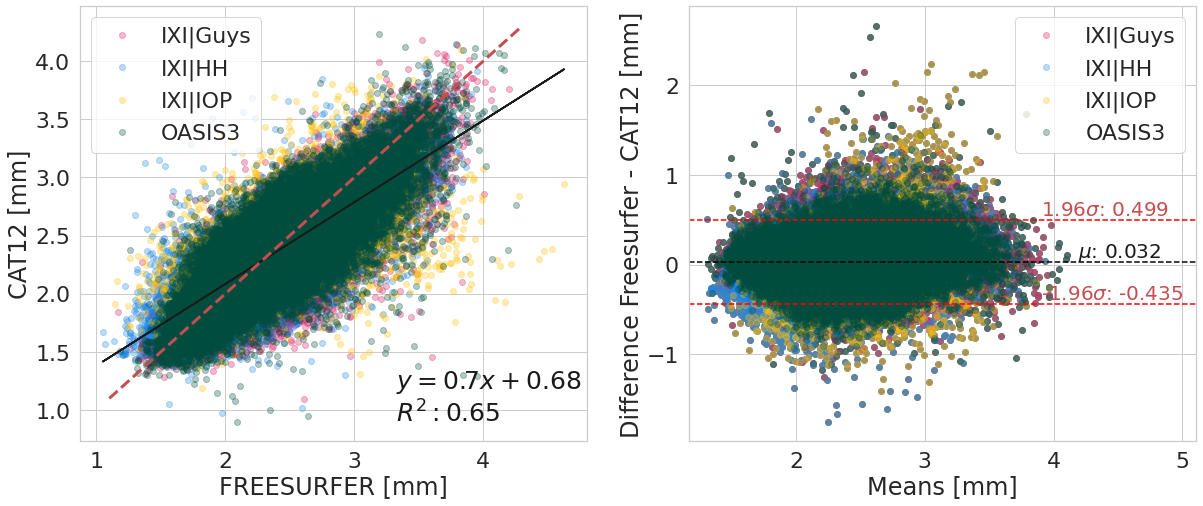

In [9]:
#@title
y_label_txt = "Difference Freesurfer - CAT12 [mm]"
bland_altman_plot(df_software.copy().reset_index(),
                  ('corticalThicknessAverage', 'FREESURFER'), 
                  ('corticalThicknessAverage', 'ACPC_CAT12'),
                  var_compare, color_pallete, x_label_reg="FREESURFER [mm]", y_label_reg="CAT12 [mm]",
                  y_label_diff="Difference Freesurfer - CAT12 [mm]")


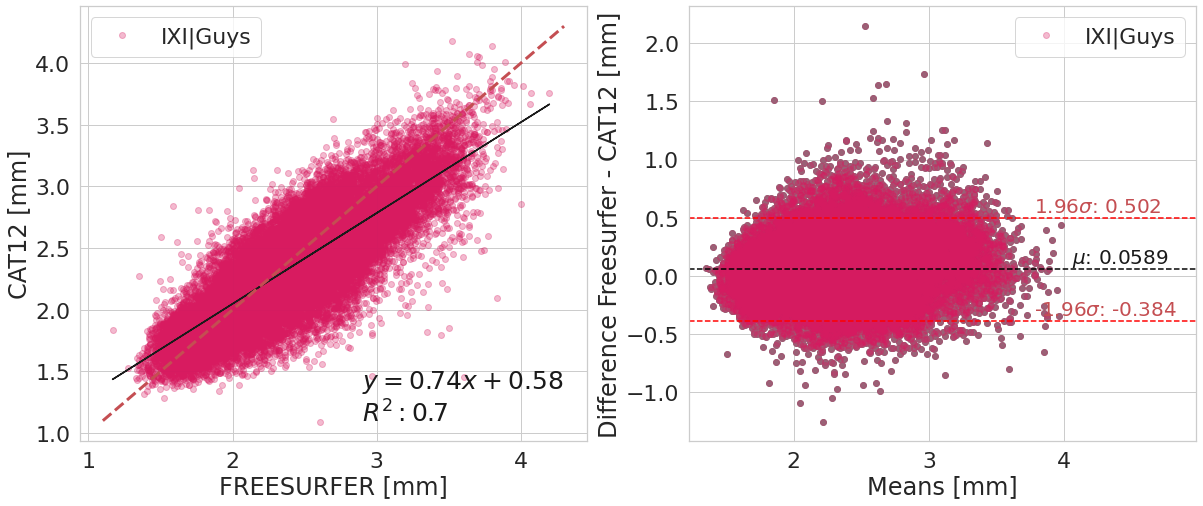

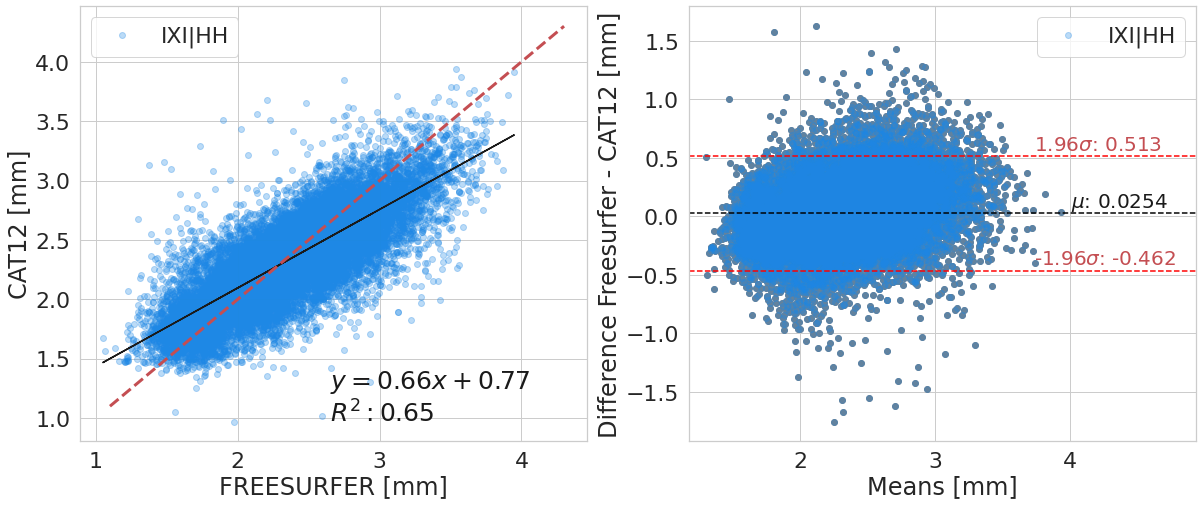

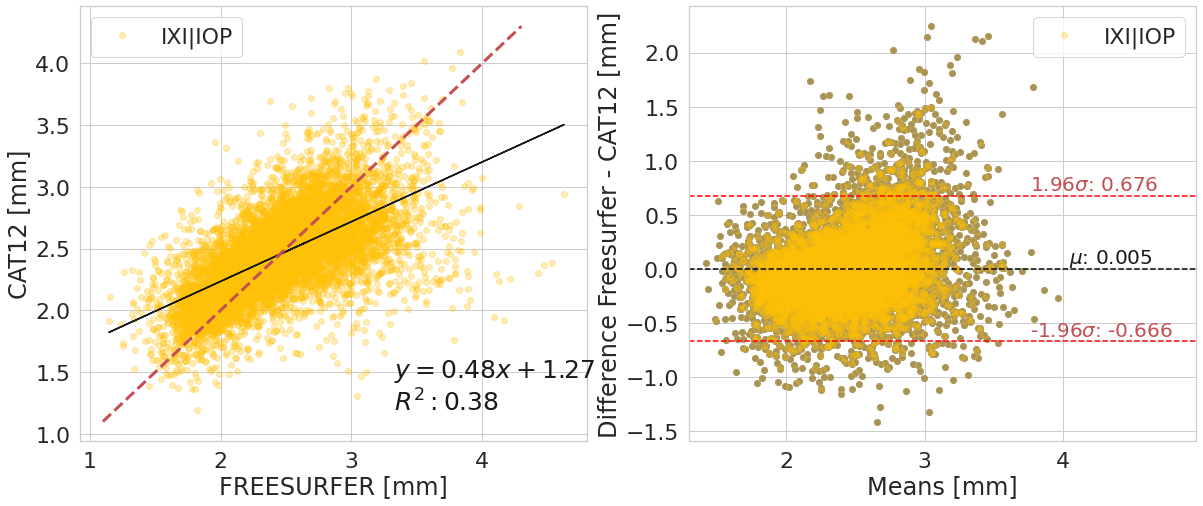

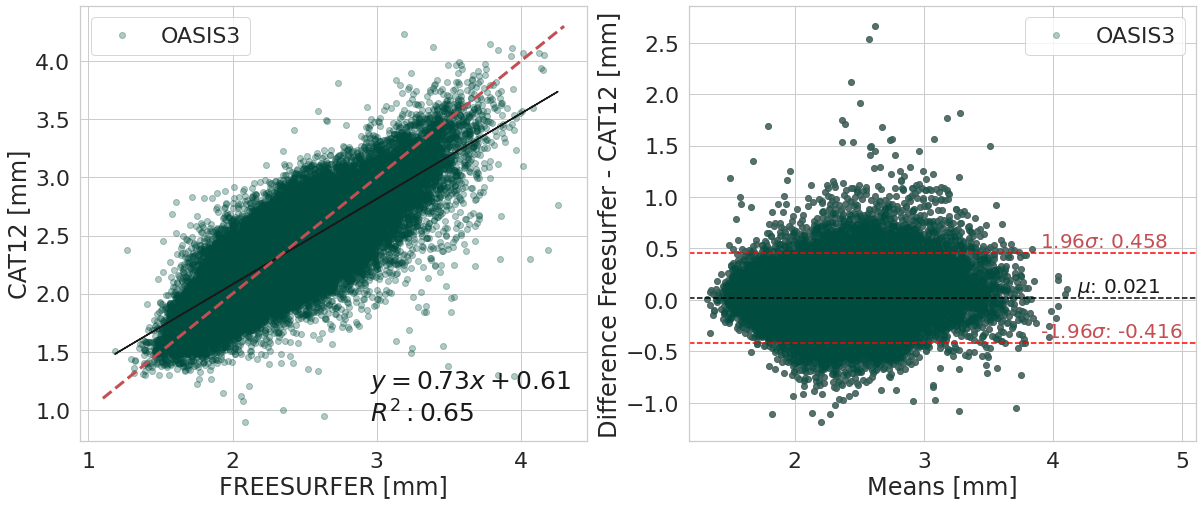

In [10]:
#@title
y_label_txt = "Difference Freesurfer - CAT12 [mm]"

for var_compared_value in pd.unique(df_software[var_compare]):
    bland_altman_plot(df_software.loc[df_software[var_compare]==var_compared_value].copy().reset_index(),
                      ('corticalThicknessAverage', 'FREESURFER'), 
                      ('corticalThicknessAverage', 'ACPC_CAT12'),
                      var_compare, color_pallete, x_label_reg="FREESURFER [mm]", y_label_reg="CAT12 [mm]",
                      y_label_diff="Difference Freesurfer - CAT12 [mm]")

In [11]:
from IPython.display import display, HTML


df_soft_filter = df_software
diff = (df_soft_filter[("corticalThicknessAverage", "FREESURFER")] - df_soft_filter[("corticalThicknessAverage", "ACPC_CAT12")])
test = pg.ttest(diff, 0)


df_means_diff = df_soft_filter[[("corticalThicknessAverage", "FREESURFER"), 
                                ("corticalThicknessAverage", "ACPC_CAT12")]].mean().to_frame().T.rename(columns={"corticalThicknessAverage": "Cortical Thickness Average Mean"})
df_means_diff["Difference FREESURFER - CAT12"] = diff.mean()


test = pg.ttest(diff, 0)

display(HTML(df_means_diff.to_html()))

display(HTML(f"<br><p>One sample t-test to verify whether the means difference is equal to zero</p>"))
display(HTML(test.to_html()))
print(f"Confidence interval (95%) of the means difference: [{round(diff.mean() - 1.96*diff.std(), 3)};{round(diff.mean() + 1.96*diff.std(), 3)}]")


/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)
/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


Confidence interval (95%) of the means difference: [-0.435;0.499]


In [12]:
#@title

df = df_software.reset_index().set_index(["subjectID", "sessionID", "run"]).join(df_subjects.reset_index().set_index(["subjectID", "sessionID", "run"]))
df.columns = ["".join(el) for el in df.columns]
df.head(3)

/tmp/ipykernel_29414/928943096.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df = df_software.reset_index().set_index(["subjectID", "sessionID", "run"]).join(df_subjects.reset_index().set_index(["subjectID", "sessionID", "run"]))


path template  \
subjectID sessionID run                                                      
sub-002   1         1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   a2009s   
                    1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   a2009s   
                    1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   a2009s   

                        repository_and_site                   roiName  \
subjectID sessionID run                                                 
sub-002   1         1              IXI|Guys  lG_Ins_lg_and_S_cent_ins   
                    1              IXI|Guys       lG_and_S_cingul-Ant   
                    1              IXI|Guys   lG_and_S_cingul-Mid-Ant   

                         corticalThicknessAverageACPC_CAT12  \
subjectID sessionID run                                       
sub-002   1         1                              3.16e+00   
                    1                              2.56e+00   
                    1                              2.69e+00   

                         corticalThicknessAverageFREESURFER  \
subjectID sessionID run                                       
sub-002   1         1                              3.06e+00   
                    1                              2.80e+00   
                    1                              2.63e+00   

                                                             path  \
subjectID sessionID run                                             
sub-002   1         1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   
                    1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   
                    1    IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   

                        repositoryName  site repository_and_site       age  \
subjectID sessionID run                                                      
sub-002   1         1              IXI  Guys            IXI|Guys  3.58e+01   
                    1              IXI  Guys            IXI|Guys  3.58e+01   
                    1              IXI  Guys            IXI|Guys  3.58e+01   

                         gender  snr_total  
subjectID sessionID run                     
sub-002   1         1    FEMALE   1.58e+01  
                    1    FEMALE   1.58e+01  
                    1    FEMALE   1.58e+01

### Participant Analysis

<img src="../resources/images/analysis_participant_simple.png" alt="Participant Analysis" style="width: 70%;"/>

In [13]:
#@title
print(f'Number of subjects in this analysis is: {len(df_software.reset_index()["subjectID"].unique())}')

Number of subjects in this analysis is: 1049


#### Compute metrics 

In [14]:
#@title
sub_grouped_by, sub_grouped_by_stats = get_regression_metrics(df_software, ['path'], (metric_analysis, pipeline1), (metric_analysis, pipeline2))

df_ct = df_software.reset_index()[["path", var_compare, "roiName", "corticalThicknessAverage"]].melt(id_vars=["path", var_compare, "roiName"])

all_subjects_icc = []

for path_sub in df_ct["path"].unique():
    df_icc_roi = pg.intraclass_corr(data=df_ct.loc[df_ct["path"] == path_sub], 
                                    targets='roiName', raters='software',
                                    ratings='value')
    df_icc_roi["path"] = path_sub

    all_subjects_icc.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])

df_icc_sub = pd.concat(all_subjects_icc).set_index("path")

df_subject_info = df_subjects.join(sub_grouped_by_stats).join(df_icc_sub[["ICC"]])
df_subject_info = df_subject_info[~df_subject_info["slope"].isna()]

sub_grouped_by_stats

slope  intercept  \
path                                                                      
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            9.76e-01   1.71e-01   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz            1.07e+00  -9.83e-02   
IXI/Guys/sub-017/anat/sub-017_T1w.nii.gz            1.04e+00   1.58e-02   
IXI/Guys/sub-019/anat/sub-019_T1w.nii.gz            9.44e-01   1.59e-01   
IXI/Guys/sub-020/anat/sub-020_T1w.nii.gz            9.85e-01   6.31e-02   
...                                                      ...        ...   
OASIS3/sub-OAS31164/ses-d0069/anat/sub-OAS31164...  8.85e-01   2.83e-01   
OASIS3/sub-OAS31165/ses-d0426/anat/sub-OAS31165...  9.27e-01   2.26e-01   
OASIS3/sub-OAS31168/ses-d0148/anat/sub-OAS31168...  9.60e-01   1.11e-01   
OASIS3/sub-OAS31169/ses-d0620/anat/sub-OAS31169...  9.00e-01   2.07e-01   
OASIS3/sub-OAS31172/ses-d0407/anat/sub-OAS31172...  9.13e-01   2.33e-01   

                                                     r_value   p_value  \
path                                                                     
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            8.71e-01  5.04e-47   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz            9.00e-01  1.88e-54   
IXI/Guys/sub-017/anat/sub-017_T1w.nii.gz            8.27e-01  2.77e-38   
IXI/Guys/sub-019/anat/sub-019_T1w.nii.gz            7.79e-01  2.11e-31   
IXI/Guys/sub-020/anat/sub-020_T1w.nii.gz            8.65e-01  1.53e-45   
...                                                      ...       ...   
OASIS3/sub-OAS31164/ses-d0069/anat/sub-OAS31164...  8.30e-01  6.43e-39   
OASIS3/sub-OAS31165/ses-d0426/anat/sub-OAS31165...  7.04e-01  1.91e-23   
OASIS3/sub-OAS31168/ses-d0148/anat/sub-OAS31168...  7.94e-01  2.43e-33   
OASIS3/sub-OAS31169/ses-d0620/anat/sub-OAS31169...  7.98e-01  6.83e-34   
OASIS3/sub-OAS31172/ses-d0407/anat/sub-OAS31172...  8.37e-01  4.61e-40   

                                                     std_err  r_square  
path                                                                    
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            4.54e-02  7.59e-01  
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz            4.28e-02  8.10e-01  
IXI/Guys/sub-017/anat/sub-017_T1w.nii.gz            5.87e-02  6.83e-01  
IXI/Guys/sub-019/anat/sub-019_T1w.nii.gz            6.29e-02  6.07e-01  
IXI/Guys/sub-020/anat/sub-020_T1w.nii.gz            4.73e-02  7.48e-01  
...                                                      ...       ...  
OASIS3/sub-OAS31164/ses-d0069/anat/sub-OAS31164...  4.91e-02  6.90e-01  
OASIS3/sub-OAS31165/ses-d0426/anat/sub-OAS31165...  7.74e-02  4.95e-01  
OASIS3/sub-OAS31168/ses-d0148/anat/sub-OAS31168...  6.09e-02  6.30e-01  
OASIS3/sub-OAS31169/ses-d0620/anat/sub-OAS31169...  5.63e-02  6.36e-01  
OASIS3/sub-OAS31172/ses-d0407/anat/sub-OAS31172...  4.94e-02  7.01e-01  

[1049 rows x 6 columns]

#### Reproducibility metrics analysis

In [15]:
df_subject_info.head(2)

repositoryName  site  \
path                                                            
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI  Guys   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz            IXI  Guys   

                                         repository_and_site subjectID  \
path                                                                     
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz            IXI|Guys   sub-002   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz            IXI|Guys   sub-016   

                                         sessionID  run       age  gender  \
path                                                                        
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz         1    1  3.58e+01  FEMALE   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz         1    1  5.52e+01    MALE   

                                          snr_total     slope  intercept  \
path                                                                       
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz   1.58e+01  9.76e-01   1.71e-01   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz   1.46e+01  1.07e+00  -9.83e-02   

                                           r_value   p_value   std_err  \
path                                                                     
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  8.71e-01  5.04e-47  4.54e-02   
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz  9.00e-01  1.88e-54  4.28e-02   

                                          r_square       ICC  
path                                                          
IXI/Guys/sub-002/anat/sub-002_T1w.nii.gz  7.59e-01  8.66e-01  
IXI/Guys/sub-016/anat/sub-016_T1w.nii.gz  8.10e-01  8.87e-01

In [16]:
#@title
df_subject_info.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                   f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}',
                                                                   f'{x["slope"].mean(): 0.2f}+/-{x["slope"].std(): 0.2f}',
                                                                   f'{x["intercept"].mean(): 0.2f}+/-{x["intercept"].std(): 0.2f}'], 
                                                                   index=['ICC', '$R^2$', 'slope', 'intercept']))

ICC          $R^2$          slope  \
repository_and_site                                                
IXI|Guys              0.82+/- 0.04   0.69+/- 0.06   0.95+/- 0.07   
IXI|HH                0.79+/- 0.07   0.65+/- 0.09   0.97+/- 0.12   
IXI|IOP               0.60+/- 0.08   0.38+/- 0.10   0.78+/- 0.12   
OASIS3                0.80+/- 0.06   0.65+/- 0.08   0.89+/- 0.08   

                         intercept  
repository_and_site                 
IXI|Guys              0.17+/- 0.17  
IXI|HH                0.09+/- 0.25  
IXI|IOP               0.54+/- 0.32  
OASIS3                0.27+/- 0.19

In [17]:
def latex_float(float_str):
    
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [18]:
#### Analysis of age effect on reproducibility metrics

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

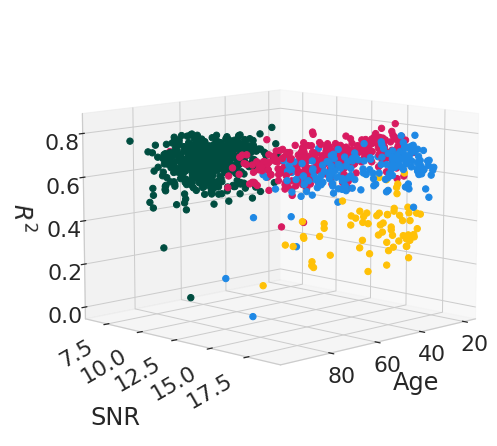

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

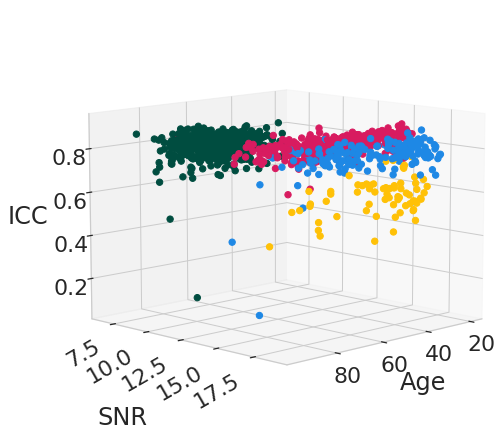

In [19]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import display, Math

reproducibility_measures = [("r_square", "$R^2$"), ("ICC", "ICC")]
for rep_measure, label_measure in reproducibility_measures:
    
    for el in df_subject_info[var_compare].unique():
        legend = el
   
        data_filtered = df_subject_info.loc[df_subject_info[var_compare] == el]
                
        x_values = data_filtered[["age", "snr_total"]]
        y_values = data_filtered[rep_measure]
        
        model = LinearRegression().fit(x_values, y_values)

        
        age_weight = latex_float(f'{model.coef_[0]: 0.1e}')
        SNR_weight = latex_float(f'{model.coef_[1]: 0.1e}')
        intercept = latex_float(f'{model.intercept_: 0.1e}')
        
        eq = f'${label_measure.replace("$", "")}_' + "{" + legend + "}" + f'={age_weight}age + {SNR_weight}SNR + {intercept}$'
        display(Math(r'{}'.format(eq)))
        
    x= df_subject_info["age"].values
    y= df_subject_info["snr_total"].values
    z= df_subject_info[rep_measure].values

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=40, c=[color_pallete[el] for el in df_subject_info[var_compare].values], marker='o', cmap=cmap, alpha=1)

    ax.set_xlabel('Age', labelpad=15)
    ax.set_ylabel('SNR', labelpad=45)
    ax.set_zlabel(label_measure, labelpad=15)

    ax.view_init(elev=10., azim=45)

    plt.subplots_adjust(bottom=0.2, top=2)
    plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')

    plt.show()
    

### ROI Analysis

<img src="../resources/images/analysis_roi_simple.png" alt="Participant Analysis" style="width: 70%;"/>

#### Compute metrics 

In [20]:
#@title
roi_grouped_by, roi_grouped_by_stats = get_regression_metrics(df_software, ["roiName", var_compare], (metric_analysis, pipeline1), (metric_analysis, pipeline2))

all_rois = []

for var in df_ct[var_compare].unique():
    for roi_name in df_ct["roiName"].unique():
        df_icc_roi = pg.intraclass_corr(data=df_ct.loc[(df_ct["roiName"] == roi_name) & (df_ct[var_compare] == var)], 
                                        targets='path', raters='software',
                                        ratings='value')
        df_icc_roi["roiName"] = roi_name
        df_icc_roi[var_compare] = var
        
        all_rois.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])
        
df_icc_rois = pd.concat(all_rois)


roi_grouped_by_stats = roi_grouped_by_stats.join(pd.concat(all_rois).set_index(["roiName", var_compare])[["ICC", "CI95%"]])

map_abbrev_to_name = df_names_rois.set_index("label")[["name"]].to_dict("series")["name"]
hem_label = {"r": "Right", "l": "Left"}

roi_grouped_by_stats["name"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: map_abbrev_to_name[x[1:]])
roi_grouped_by_stats["hem"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: hem_label[x[0].lower()])

dfs = []

rois_info = roi_grouped_by_stats.copy()
rois_info["label"] = roi_grouped_by_stats.index.get_level_values(0).str[1:].str.strip()
rois_info["hem"] = roi_grouped_by_stats.index.get_level_values(0).str[0]
rois_info = rois_info.reset_index().set_index(["label", "hem", var_compare])

for var in rois_info.index.get_level_values(2).unique():
    for hem in rois_info.index.get_level_values(1).unique():
        df_areas_metrics_var = pd.concat([df_areas, df_areas["Label"].apply(lambda x: rois_info.loc[(x, hem, var)])], axis=1)
        df_areas_metrics_var[var_compare] = var
        dfs.append(df_areas_metrics_var)
df_areas_metrics = pd.concat(dfs)
df_areas_metrics["hem"] = df_areas_metrics["roiName"].str[0]

df_icc = df_areas_metrics.pivot_table(index="name", columns=[var_compare, "hem"], values=["ICC"])

df_ci = df_areas_metrics.pivot_table(index="name", columns=[var_compare, "hem"], values=["CI95%"])

df_ci_icc = df_icc.join(df_ci) 
 
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 2)
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 1)
df_ci_icc = df_ci_icc[[df_ci_icc.columns[0], df_ci_icc.columns[-8], 
                     df_ci_icc.columns[1], df_ci_icc.columns[-7], 
                     df_ci_icc.columns[2], df_ci_icc.columns[-6], 
                     df_ci_icc.columns[3], df_ci_icc.columns[-5], 
                     df_ci_icc.columns[4], df_ci_icc.columns[-4],
                     df_ci_icc.columns[5], df_ci_icc.columns[-3], 
                     df_ci_icc.columns[6], df_ci_icc.columns[-2],
                     df_ci_icc.columns[7], df_ci_icc.columns[-1]]] 

roi_grouped_by_stats

slope  intercept   r_value  \
roiName                  repository_and_site                                  
lG_Ins_lg_and_S_cent_ins IXI|Guys             4.43e-01   1.71e+00  4.91e-01   
                         IXI|HH               2.48e-01   2.13e+00  2.69e-01   
                         IXI|IOP              2.29e-01   2.09e+00  2.97e-01   
                         OASIS3               4.76e-01   1.62e+00  5.30e-01   
lG_and_S_cingul-Ant      IXI|Guys             5.44e-01   1.28e+00  5.91e-01   
...                                                ...        ...       ...   
rS_temporal_sup          OASIS3               8.28e-01   3.38e-01  8.24e-01   
rS_temporal_transverse   IXI|Guys             7.02e-01   7.90e-01  4.96e-01   
                         IXI|HH               7.15e-01   7.17e-01  4.46e-01   
                         IXI|IOP              5.92e-01   1.12e+00  3.64e-01   
                         OASIS3               7.91e-01   6.32e-01  5.63e-01   

                                                p_value   std_err  r_square  \
roiName                  repository_and_site                                  
lG_Ins_lg_and_S_cent_ins IXI|Guys              2.44e-20  4.46e-02  2.41e-01   
                         IXI|HH                2.76e-04  6.69e-02  7.22e-02   
                         IXI|IOP               1.46e-02  9.12e-02  8.83e-02   
                         OASIS3                5.94e-37  3.44e-02  2.81e-01   
lG_and_S_cingul-Ant      IXI|Guys              9.88e-31  4.22e-02  3.49e-01   
...                                                 ...       ...       ...   
rS_temporal_sup          OASIS3               6.46e-123  2.57e-02  6.80e-01   
rS_temporal_transverse   IXI|Guys              8.15e-21  6.97e-02  2.46e-01   
                         IXI|HH                4.06e-10  1.08e-01  1.99e-01   
                         IXI|IOP               2.46e-03  1.88e-01  1.33e-01   
                         OASIS3                1.89e-42  5.25e-02  3.17e-01   

                                                   ICC         CI95%  \
roiName                  repository_and_site                           
lG_Ins_lg_and_S_cent_ins IXI|Guys             4.88e-01   [0.4, 0.57]   
                         IXI|HH               2.68e-01   [0.13, 0.4]   
                         IXI|IOP              2.87e-01  [0.05, 0.49]   
                         OASIS3               5.27e-01  [0.46, 0.59]   
lG_and_S_cingul-Ant      IXI|Guys             5.89e-01  [0.51, 0.66]   
...                                                ...           ...   
rS_temporal_sup          OASIS3               8.24e-01  [0.79, 0.85]   
rS_temporal_transverse   IXI|Guys             4.68e-01  [0.38, 0.55]   
                         IXI|HH               4.00e-01  [0.27, 0.52]   
                         IXI|IOP              3.25e-01  [0.09, 0.52]   
                         OASIS3               5.32e-01  [0.47, 0.59]   

                                                                                           name  \
roiName                  repository_and_site                                                      
lG_Ins_lg_and_S_cent_ins IXI|Guys             Long insular gyrus and central sulcus of the i...   
                         IXI|HH               Long insular gyrus and central sulcus of the i...   
                         IXI|IOP              Long insular gyrus and central sulcus of the i...   
                         OASIS3               Long insular gyrus and central sulcus of the i...   
lG_and_S_cingul-Ant      IXI|Guys              Anterior part of the cingulate gyrus and sulcus    
...                                                                                         ...   
rS_temporal_sup          OASIS3                                       Superior temporal sulcus    
rS_temporal_transverse   IXI|Guys                                    Transverse temporal sulcus   
                         IXI|HH                                   

In [21]:
import pingouin as pg

all_df = []
for var in df_ct[var_compare].unique():
    for roiname in df_ct['roiName'].unique():
        df_posthoc = pg.pairwise_ttests(data=df_ct.loc[(df_ct['roiName'] == roiname) & (df_ct[var_compare] == var)], 
                                        dv='value', within='software', subject='path',
                                     parametric=True, padjust='fdr_bh', effsize='cohen')

        # Pretty printing of table
        df_posthoc['roiName'] = roiname
        df_posthoc[var_compare] = var
        all_df.append(df_posthoc)
df_f_p_value = pd.concat(all_df)
df_f_p_value.head(4)

Contrast           A           B  Paired  Parametric         T       dof  \
0  software  ACPC_CAT12  FREESURFER    True        True -7.13e-01  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True -1.83e+01  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  7.73e+00  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  5.18e-01  3.11e+02   

  alternative     p-unc       BF10     cohen                   roiName  \
0   two-sided  4.76e-01      0.082 -4.08e-02  lG_Ins_lg_and_S_cent_ins   
0   two-sided  1.85e-51  9.934e+47 -9.42e-01       lG_and_S_cingul-Ant   
0   two-sided  1.45e-13  3.845e+10  3.97e-01   lG_and_S_cingul-Mid-Ant   
0   two-sided  6.05e-01      0.073  2.17e-02  lG_and_S_cingul-Mid-Post   

  repository_and_site  
0            IXI|Guys  
0            IXI|Guys  
0            IXI|Guys  
0            IXI|Guys

In [22]:
#@title

df_sorted = pd.pivot_table(roi_grouped_by_stats.reset_index(), index="name", values=["r_square"], columns=[var_compare, "hem"])
df_sorted

r_square            \
repository_and_site                                 IXI|Guys             
hem                                                     Left     Right   
name                                                                     
Angular gyrus                                       6.29e-01  6.28e-01   
Anterior occipital sulcus and preoccipital notch    4.92e-01  5.44e-01   
Anterior part of the cingulate gyrus and sulcus     3.49e-01  3.31e-01   
Anterior segment of the circular sulcus of the ...  1.10e-01  2.46e-01   
Anterior transverse collateral sulcus               3.67e-03  1.26e-02   
...                                                      ...       ...   
Temporal pole                                       1.77e-01  3.16e-01   
Transverse frontopolar gyri and sulci               3.25e-01  4.72e-01   
Transverse temporal sulcus                          5.10e-01  2.46e-01   
Triangular part of the inferior frontal gyrus       6.30e-01  6.75e-01   
Vertical ramus of the anterior segment of the l...  2.76e-01  2.35e-01   

                                                                        \
repository_and_site                                   IXI|HH             
hem                                                     Left     Right   
name                                                                     
Angular gyrus                                       6.89e-01  6.09e-01   
Anterior occipital sulcus and preoccipital notch    3.70e-01  5.21e-01   
Anterior part of the cingulate gyrus and sulcus     3.20e-01  4.29e-01   
Anterior segment of the circular sulcus of the ...  8.89e-02  1.70e-01   
Anterior transverse collateral sulcus               1.49e-02  1.97e-02   
...                                                      ...       ...   
Temporal pole                                       4.99e-01  3.75e-01   
Transverse frontopolar gyri and sulci               4.36e-01  5.17e-01   
Transverse temporal sulcus                          4.22e-01  1.99e-01   
Triangular part of the inferior frontal gyrus       5.94e-01  5.83e-01   
Vertical ramus of the anterior segment of the l...  2.55e-01  2.40e-01   

                                                                        \
repository_and_site                                  IXI|IOP             
hem                                                     Left     Right   
name                                                                     
Angular gyrus                                       4.25e-01  3.62e-01   
Anterior occipital sulcus and preoccipital notch    4.99e-01  3.88e-01   
Anterior part of the cingulate gyrus and sulcus     1.13e-01  1.38e-01   
Anterior segment of the circular sulcus of the ...  5.75e-02  1.25e-02   
Anterior transverse collateral sulcus               2.35e-03  2.21e-04   
...                                                      ...       ...   
Temporal pole                                       1.85e-01  9.46e-02   
Transverse frontopolar gyri and sulci               9.51e-02  2.84e-01   
Transverse temporal sulcus                          4.97e-01  1.33e-01   
Triangular part of the inferior frontal gyrus       5.60e-01  4.84e-01   
Vertical ramus of the anterior segment of the l...  2.01e-01  1.89e-01   

                                                                        
repository_and_site                                   OASIS3            
hem                                                     Left     Right  
name                                                                    
Angular gyrus                                       5.78e-01  6.87e-01  
Anterior occipital sulcus and preoccipital notch    3.45e-01  5.30e-01  
Anterior part of the cingulate gyrus and sulcus     1.87e-01  1.98e-01  
Anterior segment of the circular sulcus of the ...  2.34e-01  2.22e-01  
Anterior transverse collateral sulcus               5.20e-05  5.61e-03  
...                                                      ...  

#### Reproducibility metrics analysis

In [23]:
#@title
roi_grouped_by_stats.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                        f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}',
                                                                        f'{x["slope"].mean(): 0.2f}+/-{x["slope"].std(): 0.2f}',
                                                                        f'{x["intercept"].mean(): 0.2f}+/-{x["intercept"].std(): 0.2f}'], 
                                                                        index=['ICC', '$R^2$', 'slope', 'intercept']))


ICC          $R^2$          slope  \
repository_and_site                                                
IXI|Guys              0.60+/- 0.18   0.40+/- 0.19   0.68+/- 0.22   
IXI|HH                0.59+/- 0.18   0.39+/- 0.19   0.72+/- 0.23   
IXI|IOP               0.44+/- 0.18   0.24+/- 0.16   0.56+/- 0.25   
OASIS3                0.59+/- 0.20   0.39+/- 0.21   0.64+/- 0.23   

                         intercept  
repository_and_site                 
IXI|Guys              0.82+/- 0.63  
IXI|HH                0.67+/- 0.61  
IXI|IOP               1.09+/- 0.76  
OASIS3                0.88+/- 0.59

##### Mean per lobe

In [24]:
#@title

to_group_by = ["Area"]
df_areas_metrics_grouped = df_areas_metrics.groupby(to_group_by + [var_compare, "hem"]).mean()
df_lobes = pd.pivot_table(df_areas_metrics_grouped.reset_index(), index=to_group_by, values=["r_square"], columns=[var_compare])

df_lobes

r_square                              
repository_and_site            IXI|Guys    IXI|HH   IXI|IOP    OASIS3
Area                                                                 
 Frontal Lobe                  4.01e-01  4.18e-01  2.55e-01  3.31e-01
 Insula                        3.42e-01  2.34e-01  2.02e-01  3.65e-01
 Limbic lobe                   3.23e-01  3.23e-01  1.90e-01  3.11e-01
 Parietal lobe                 5.14e-01  4.92e-01  2.99e-01  5.69e-01
 Temporal and occipital lobes  4.15e-01  4.26e-01  2.49e-01  4.21e-01

#### Paired t-test

In [25]:
all_df = []
for var in df_ct[var_compare].unique():
    for roiname in df_ct['roiName'].unique():
        df_posthoc = pg.pairwise_ttests(data=df_ct.loc[(df_ct['roiName'] == roiname) & (df_ct[var_compare] == var)], 
                                        dv='value', within='software', subject='path',
                                     parametric=True, padjust='fdr_bh', effsize='cohen')

        # Pretty printing of table
        df_posthoc['roiName'] = roiname
        df_posthoc[var_compare] = var
        all_df.append(df_posthoc)
df_f_p_value = pd.concat(all_df)
df_f_p_value.head(4)

Contrast           A           B  Paired  Parametric         T       dof  \
0  software  ACPC_CAT12  FREESURFER    True        True -7.13e-01  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True -1.83e+01  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  7.73e+00  3.11e+02   
0  software  ACPC_CAT12  FREESURFER    True        True  5.18e-01  3.11e+02   

  alternative     p-unc       BF10     cohen                   roiName  \
0   two-sided  4.76e-01      0.082 -4.08e-02  lG_Ins_lg_and_S_cent_ins   
0   two-sided  1.85e-51  9.934e+47 -9.42e-01       lG_and_S_cingul-Ant   
0   two-sided  1.45e-13  3.845e+10  3.97e-01   lG_and_S_cingul-Mid-Ant   
0   two-sided  6.05e-01      0.073  2.17e-02  lG_and_S_cingul-Mid-Post   

  repository_and_site  
0            IXI|Guys  
0            IXI|Guys  
0            IXI|Guys  
0            IXI|Guys

In [26]:
df_f_p_value["hem"] = df_f_p_value.apply(lambda x: hem_label[x.roiName[0].lower()], axis=1)
df_f_p_value["name"] = df_f_p_value.apply(lambda x: map_abbrev_to_name[x.roiName[1:]], axis=1)

# Bonferroni correction
significance_level = .05

df_f_p_value["p-value"] = df_f_p_value["p-unc"].apply(lambda x: min(x*df_f_p_value.shape[0], 1))
df_f_p_value_rejected = df_f_p_value[df_f_p_value["p-value"] < significance_level]

df_f_p_value["cohen"] = df_f_p_value["cohen"].astype(float).round(2).abs()
df_f_p_value["cohen-p-value"] = df_f_p_value[["p-value", "cohen"]].apply(lambda x: f'{x["cohen"]}*' if x['p-value'] < significance_level else f'{x["cohen"]}', axis=1).astype(str)


df_p_value = pd.pivot_table(df_f_p_value.reset_index(), index="name", values=["cohen-p-value"], columns=[var_compare, "hem"], aggfunc=lambda x: ' '.join(x))
df_p_value


cohen-p-value         \
repository_and_site                                     IXI|Guys          
hem                                                         Left  Right   
name                                                                      
Angular gyrus                                              0.73*  0.88*   
Anterior occipital sulcus and preoccipital notch            0.02   0.02   
Anterior part of the cingulate gyrus and sulcus            0.94*  0.73*   
Anterior segment of the circular sulcus of the ...         0.82*   0.11   
Anterior transverse collateral sulcus                      0.67*  0.48*   
...                                                          ...    ...   
Temporal pole                                              1.19*  1.35*   
Transverse frontopolar gyri and sulci                      0.76*  0.35*   
Transverse temporal sulcus                                 0.25*  0.57*   
Triangular part of the inferior frontal gyrus              0.82*  0.82*   
Vertical ramus of the anterior segment of the l...         1.09*  0.42*   

                                                                          \
repository_and_site                                IXI|HH        IXI|IOP   
hem                                                  Left  Right    Left   
name                                                                       
Angular gyrus                                        0.5*  0.55*    0.22   
Anterior occipital sulcus and preoccipital notch     0.09  0.31*    0.01   
Anterior part of the cingulate gyrus and sulcus     0.81*  0.48*   0.64*   
Anterior segment of the circular sulcus of the ...   0.17  0.42*    0.48   
Anterior transverse collateral sulcus               0.88*  0.85*   2.38*   
...                                                   ...    ...     ...   
Temporal pole                                       1.06*   1.1*   1.91*   
Transverse frontopolar gyri and sulci                0.12    0.0    0.45   
Transverse temporal sulcus                           0.04  0.33*    0.17   
Triangular part of the inferior frontal gyrus       0.54*  0.62*   0.42*   
Vertical ramus of the anterior segment of the l...  1.07*  0.31*   1.53*   

                                                                         
repository_and_site                                       OASIS3         
hem                                                 Right   Left  Right  
name                                                                     
Angular gyrus                                        0.34  0.25*  0.69*  
Anterior occipital sulcus and preoccipital notch     0.13   0.09  0.28*  
Anterior part of the cingulate gyrus and sulcus      0.56  0.21*  0.44*  
Anterior segment of the circular sulcus of the ...   0.42  1.14*  0.89*  
Anterior transverse collateral sulcus               1.85*   0.19  0.44*  
...                                                   ...    ...    ...  
Temporal pole                                       2.04*  0.83*  0.95*  
Transverse frontopolar gyri and sulci                0.25  0.65*  0.51*  
Transverse temporal sulcus                           0.26  0.45*  0.75*  
Triangular part of the inferior frontal gyrus       0.65*  0.28*   0.11  
Vertical ramus of the anterior segment of the l...   1.4*  1.32*  1.12*  

[74 rows x 8 columns]

In [27]:
##### Number of regions per site in which the hypothesis was rejected

In [28]:
#@title
print(f"Number of ROIs with at least on group that rejected the paired t-test hypothesis: {df_f_p_value_rejected.reset_index().roiName.unique().shape[0]}")

Number of ROIs with at least on group that rejected the paired t-test hypothesis: 145


In [29]:
#@title
df_f_p_value_rejected.reset_index().groupby(var_compare).count()[["name"]]

name
repository_and_site      
IXI|Guys              132
IXI|HH                116
IXI|IOP                94
OASIS3                130

## Modelling age using cortical thickness values

In [30]:
df_cortical = pd.pivot_table(df_software_raw, index="path", columns=["software", "template", "roiName"], 
                             values=df_software_raw.loc[:, ~df_software_raw.columns.isin(["software", "template", "roiName", "path", "age", "run"])])


df_age = df_subjects[["age", "gender", var_compare]]
df_age.columns=pd.MultiIndex.from_tuples([("age", "", "", ""), ("gender", "", "", ""), (var_compare, "", "", "")])


df_feat_raw = df_age.join(df_cortical).dropna().sample(frac=1)

In [31]:
import statsmodels.api as sm
from scipy import stats


map_df_p = {}
for soft in ["FREESURFER", "ACPC_CAT12"]:
    X = df_feat_raw[("corticalThicknessAverage", soft, "a2009s")]
    #X = X.rename(columns={el: f'{hem_names[el[0]]} {df_names_rois.loc[df_names_rois["label"] == el[1:]]["name"].iloc[0]}' for el in X.columns})
    y = df_feat_raw["age"]

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

    map_df_p[soft] = pd.DataFrame(est2.summary().tables[1].data[1:], columns=est2.summary().tables[1].data[0]).rename(columns={"": "roiName"})


                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     18.25
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          3.28e-190
Time:                        18:17:09   Log-Likelihood:                -3706.6
No. Observations:                1048   AIC:                             7711.
Df Residuals:                     899   BIC:                             8449.
Df Model:                         148                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/tmp/ipykernel_29414/546213685.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  X = df_feat_raw[("corticalThicknessAverage", soft, "a2009s")]
/tmp/ipykernel_29414/546213685.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  X = df_feat_raw[("corticalThicknessAverage", soft, "a2009s")]


In [32]:
areas_relation_age_fs = map_df_p["FREESURFER"].loc[map_df_p["FREESURFER"]["P>|t|"].astype(float) < 0.05]["roiName"].to_list()
areas_relation_age_cat12 = map_df_p["ACPC_CAT12"].loc[map_df_p["ACPC_CAT12"]["P>|t|"].astype(float) < 0.05]["roiName"].to_list()

areas_relation_age_fs.remove('const')
areas_relation_age_cat12.remove('const')

intersection_areas = list(set(areas_relation_age_fs) & set(areas_relation_age_cat12))

print("Overlap ROIs")
df_overlap = df_areas_metrics.loc[df_areas_metrics["roiName"].isin(intersection_areas)].groupby(["roiName", "name"]).mean()[["r_square"]]
df_overlap

Overlap ROIs


r_square
roiName                   name                                                        
lG_front_inf-Triangul     Triangular part of the inferior frontal gyrus       6.03e-01
lG_front_sup              Superior frontal gyrus                              6.60e-01
lG_oc-temp_med-Lingual    Lingual gyrus                                       2.66e-01
lS_orbital_med-olfact     Medial orbital sulcus                               2.67e-02
rG_pariet_inf-Angular     Angular gyrus                                       5.71e-01
rG_temp_sup-G_T_transv    Anterior transverse temporal gyrus                  2.81e-01
rPole_occipital           Occipital pole                                      3.43e-01
rS_oc_sup_and_transversal Superior occipital sulcus and transverse occipi...  4.81e-01
rS_precentral-sup-part    Superior part of the precentral sulcus              4.31e-01

In [33]:
cat12_rois_important_non_overlap = [el for el in areas_relation_age_cat12 if el not in intersection_areas]
df_cat12_important = df_areas_metrics.loc[df_areas_metrics["roiName"].isin(cat12_rois_important_non_overlap)].groupby(["roiName", "name"]).mean()[["r_square"]]

fs_rois_important_non_overlap =  [el for el in areas_relation_age_fs if el not in intersection_areas]
df_fs_important = df_areas_metrics.loc[df_areas_metrics["roiName"].isin(fs_rois_important_non_overlap)].groupby(["roiName", "name"]).mean()[["r_square"]]

display(HTML(f"<br><h5>FreeSurfer</h5>"))
display(HTML(df_fs_important.to_html()))

display(HTML(f"<br><h5>CAT12</h5>"))
display(HTML(df_cat12_important.to_html()))

In [34]:
df_cat12_important["type"] = "non-overlapping"
df_overlap["type"] = "overlapping"
df_fs_important["type"] = "non-overlapping"
df_fs_all = pd.concat([df_overlap, df_fs_important])
df_cat12_all = pd.concat([df_overlap, df_cat12_important])

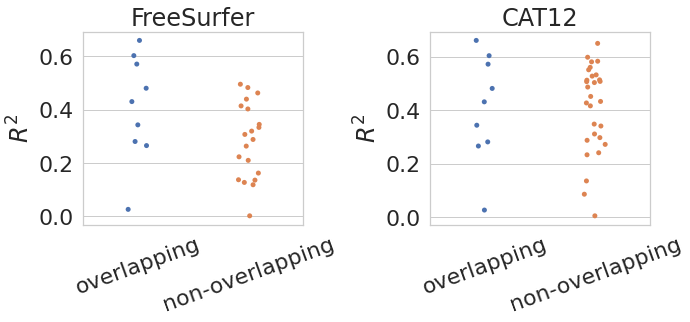

In [35]:
fig = plt.figure(1, figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
sns.stripplot(data=df_fs_all, x="type", y="r_square")
plt.xticks(rotation=20)
plt.ylabel("$R^2$")
plt.xlabel("")
plt.title("FreeSurfer")

ax = fig.add_subplot(1, 2, 2)
sns.stripplot(data=df_cat12_all, x="type", y="r_square")
plt.ylabel("$R^2$")
plt.xticks(rotation=20)
plt.xlabel("")
plt.title("CAT12")

plt.tight_layout()


In [41]:
df_test_fs = pg.ttest(df_fs_all.loc[df_fs_all["type"] == "non-overlapping"]["r_square"],
                      df_fs_all.loc[df_fs_all["type"] == "overlapping"]["r_square"])

df_test_cat12 = pg.ttest(df_cat12_all.loc[df_cat12_all["type"] == "non-overlapping"]["r_square"],
                         df_cat12_all.loc[df_cat12_all["type"] == "overlapping"]["r_square"])


display(HTML(f"<br><h5>FreeSurfer</h5>"))
display(HTML(df_test_fs.to_html()))

display(HTML(f"<br><h5>CAT12</h5>"))
display(HTML(df_test_cat12.to_html()))